# The DDPM Architecutre

The DDPM paper uses a custom archituecture based off the PixleCNN++ paper, which is based on papers like U-Net and Wide ResNet which we will be breaking down in this notebook. 

## Table of Contents

- [The U-Net](#the-u-net)
- [The DDPM Architecture](#the-ddpm-architecutre)
- [GroupNorm](#groupnorm)
- [Sinusoidal Time Embeddings](#sinusoidal-time-embeddings)
- [Sigmoid Linear Unit](#sigmoid-linear-unit)
- [Self-Attention and the Attention Block](#self-attention-and-the-attention-block)
- [Downsampling block](#downsampling-block)
- [MidBlock (Bottleneck)](#midblock-bottneck)
- [Upsampling block](#upsampling-block)
- [Putting everything together](#putting-everything-together)

# The U-Net

At the high level, the shape of the DDPM network resembles the U-Net architecture, pictured below. The U-Net, like ResNet, is mostly composed of convolutional layers, but ResNets were developed for classifying an image as a whole, whereas U-Net was developed for medical segmentation tasks that predict an output class such as "this is part of a tumour" for each input pixel in the image. By combining both U-Net and ResNet, the DDPM network has to both get an understanding of the global structure of the image (like ResNet), and also the ability to make fine-grained predictions at the pixel level (like U-Net).

<img src="references/U-Net Architecture.png" alt="U-Net Architecture">
<figcaption><code>Fig. 1</code> from Ronneberger et al. (2015) in <a href="https://arxiv.org/pdf/1505.04597#page=2">U-Net: Convolutional Networks for Biomedical Image Segmentation</a></figcaption>

In the diagram, the grey rectanges represent tensors where the width of the rectangle is the number of channels (i.e. initally 3 channels for RGB images), and the height of the rectangle being the number of spatial dimensions (i.e. initally heigh x width dimensions).

The U-Net can be divided into three main parts:
- **Downsampling** part (as called the "Encoder") - Starts at the very left of the diagram until reaching the bottom. Each downsampling block represents applying some convolutional layers followed by a max pooling downsampling operation, progressively reducing spaital dimensions while increasing the number of channels.
- **Bottleneck** part - Represented by the bottom row of the diagram. Just a couple of convolutions that represent the most compressed represntation. Has the highest number of channels and the lowest number of spatial dimensions. 
- **Upsampling** part (as called the "Decoder") - Starts at the last tensor on the bottom row until the very right of the diagram. Each upsampling block represents applying some convolution layers followed by a **transposed convolution** upsampling operation, progressively increasing the spatial dimensions while decreasing the number of channels. Also, uses skip connections from the **downsampling** part to bring back low level spatial details and combines them with high level features from the deeper layers. 

While regular convolutions perform a sliding window operation where the input values are combined into producing a single output value, transposed convolutions do the opposite - each input value contribute to multiple output values through the kernel weights ("spreading out" the in put values).


<img src="references/transposed_conv.png" alt="Transposed Convolution" width="911" height="298">
<figcaption><code>Fig. 14.10.1</code> in <a href="https://d2l.ai/chapter_computer-vision/transposed-conv.html">Dive into Deep Learning</a></figcaption>


Finally, there is a final convolution that converts the latents back to the desired number of ouput channels. In the case of medical segmentation, there would be one channel for each class of tumor that you want to detect. In the case of image diffusion models, there will be 1 or 3 output channels (greyscale or RGB).

# The DDPM Architecture

<img src="references/DDPM-architecture.png" 
alt="U-Net Architecture\"
data-mermaid="
graph TD
    subgraph DDPM Architecture
        subgraph Overview
            MTime[Num Noise Steps] --> MTimeLayer[SinusoidalEmbedding<br/>Linear: Steps -> 4C<br/>GELU<br/>Linear: 4C -> 4C]
            MTimeLayer -->|emb|DownBlock0 & DownBlock1 & DownBlock2 & MidBlock & UpBlock0 & UpBlock1 & OutBlock
            Image -->|3, H| InConv[7x7 Conv<br/>Padding 3] -->|C, H| DownBlock0 -->|C, H/2| DownBlock1 -->|2C,H/4| DownBlock2 -->|4C,H/4| MidBlock -->|4C,H/4| UpBlock0 -->|2C,H/2| UpBlock1 -->|C,H| OutBlock[Residual Block] -->|C,H| FinalConv[1x1 Conv] -->|3,H| Output
            DownBlock2 -->|4C,H/4| UpBlock0
            DownBlock1 -->|2C,H/2| UpBlock1
        end
end
">

The model used in the paper, shown above, looks very similar to the U-Net. It has the same three part stucture with **downsampling** parts (DownBlocks), a **bottleneck** part (MidBlock), and **upsampling** parts (Upblocks). However, the DDPM architecture also has many differences. The most notable difference is, in addition to the an image input, there is also a single integer represeting the number of steps of noise added. Other differences in the DDPM model include: group normalization, sinusoidal time embeddings, new nonlineararities (SiLu), Self-attention, and residual connections instead of concatenation for skip connections. 

We will dive deeper and implemenet each part of this architecture separately in this notebooks and then finally put everything together at the end. 



In [43]:
from typing import Optional, Union
import matplotlib.pyplot as plt
import torch as t
from einops import rearrange
from fancy_einsum import einsum
from torch import nn
import tests.unet_architecture_tests

# GroupNorm

<img src="references/groupnorm.png" alt="GroupNorm">
<figcaption><code>Fig. 2</code> from Wu and He (2018) in <a href="https://arxiv.org/pdf/1803.08494#page=3">Group Normalization</a></figcaption>

In our previous "toy model" notebook, we had a **Layer Normalization** that preprocessed each training example by computing the mean and standard deviation across all channels.

In **Group Normalization** we divide our chanels into some number of groups, and we calculate the mean and standard deviation for each training example AND group. For exmaple, when the number of groups is 1, GroupNorm is can be expressed to LayerNorm. The main difference being that while LayerNorm expects the channel embedding to be last (the PyTorch convention for NLP), GroupNorm expects the channel dimension to be right after the batch dimensions (the PyTorch convention for images).

The core concept for Group norm is that it divides channels into groups and normalizes within each group for each sample independently. Features within channels often have meanintful relationships (i.e. edge detectors or color channels), by grouping channels together, we maintain these relatinoships while getting the benefits of normalization. In addition, we get more benefits like batch-size independence and more stable training. 

For more intuition, read the paper [Group Normalization](https://arxiv.org/pdf/1803.08494). Also, see [pytorch implementation](https://pytorch.org/docs/stable/_modules/torch/nn/modules/normalization.html#GroupNorm).

In [44]:
class GroupNorm(nn.Module):
    def __init__(
        self,
        num_groups: int,
        num_channels: int,
        eps: float = 1e-5,
        affine: bool = True, 
        device: Optional[Union[t.device, str]] = None,
        dtype: Optional[t.dtype] = None,
    ) -> None:
        super().__init__()
        assert num_channels % num_groups == 0
        self.num_groups = num_groups
        self.num_channels = num_channels
        self.eps = eps
        self.affine = affine # if true, this module has learnable per-channel affine parameters initialized to ones (for weights) and zeros (for biases)
        if self.affine:
            self.weight = nn.Parameter(t.empty((self.num_channels,), device=device, dtype=dtype))  
            self.bias = nn.Parameter(t.empty((self.num_channels,), device=device, dtype=dtype)) 
        else:
            self.register_parameter("weight", None)
            self.register_parameter("bias", None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        """Initialize the weight and bias, if applicable."""
        if self.affine:
            nn.init.ones_(self.weight)
            nn.init.zeros_(self.bias)

    def forward(self, x: t.Tensor) -> t.Tensor:
        """Apply normalization to each group of channels.

        x: shape (batch, channels, height, width)
        out: shape (batch, channels, height, width)
        """
        # split into groups
        x = rearrange(x, "n (g c) h w -> n g c h w", g=self.num_groups) 

        # calculate mean and variance
        dim = (2, 3, 4)
        mean = x.mean(dim=dim, keepdim=True)
        var = x.var(dim=dim, keepdim=True, unbiased=False)

        # normalize
        x = x - mean
        x = x / ((var + self.eps) ** 0.5)

        # reassemble to original shape
        x = rearrange(x, "n g c h w -> n (g c) h w")

        # apply learned scale (weight) and bias parameters per-channel if affine=True
        if self.affine:
            x = x * self.weight.view(1, -1, 1, 1)
            x = x + self.bias.view(1, -1, 1, 1)
        return x

In [45]:
tests.unet_architecture_tests.test_groupnorm(GroupNorm, affine=False)
tests.unet_architecture_tests.test_groupnorm(GroupNorm, affine=True)

tests.unet_architecture_tests.test_groupnorm passed in 0.00s.
tests.unet_architecture_tests.test_groupnorm passed in 0.00s.


# Sinusoidal Time Embeddings

In BERT and GPT, the mapping from the sequence position to the embedding vector was learned by the model during training. However, it is also common to simply hardcode this mapping using a combination of sine and cosine functions at different frequences. By hardcoding the mapping, we slightly reduce the nubmer of paramters without sacrificing much performance. 

In our model, instead of sequence position, our model needs to know the number of noise steps were added to be able to anticipate how much noise to expect since the amount of noise increases with number of steps.

TLDR - Sinusoidal embeddings allows a simple linear transformation in of the "query" and "key" vectors can express relative positional relationships (i.e. this positions attends to information k positions ago). For more intuition, see [this blog post](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/). We will be reproducing, Figure 2 and Figure 3 from this blog.



<img src="references/positional_embedding.png" alt="Positional Embedding">
<figcaption>From Calvo (2018) in <a href="https://medium.com/dissecting-bert/dissecting-bert-part-1-d3c3d495cdb3">Dissecting BERT Part 1: The Encoder</a> (different blog post from the one previously mentioned)</figcaption>

In [46]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, embedding_size: int):
        super().__init__()
        self.embedding_size = embedding_size
        wk = 1.0 / 10000.0 ** ((t.arange(0, embedding_size, 2)) / embedding_size)
        self.register_buffer("wk", wk)

    def forward(self, x: t.Tensor) -> t.Tensor:
        """
        x: shape (batch, ) - for each batch element, the number of noise steps
        Out: shape (batch, embedding_size)
        """
        wkx = t.einsum("x, k -> xk", x, self.wk)
        stacked = t.stack((wkx.sin(), wkx.cos()), dim=-1)
        flat = rearrange(stacked, "batch k func -> batch (k func)", func=2)
        return flat

[Text(0.5, 0, 'Num Steps'),
 Text(0, 0.5, 'Num Steps'),
 Text(0.5, 1.0, 'Dot product of position embeddings')]

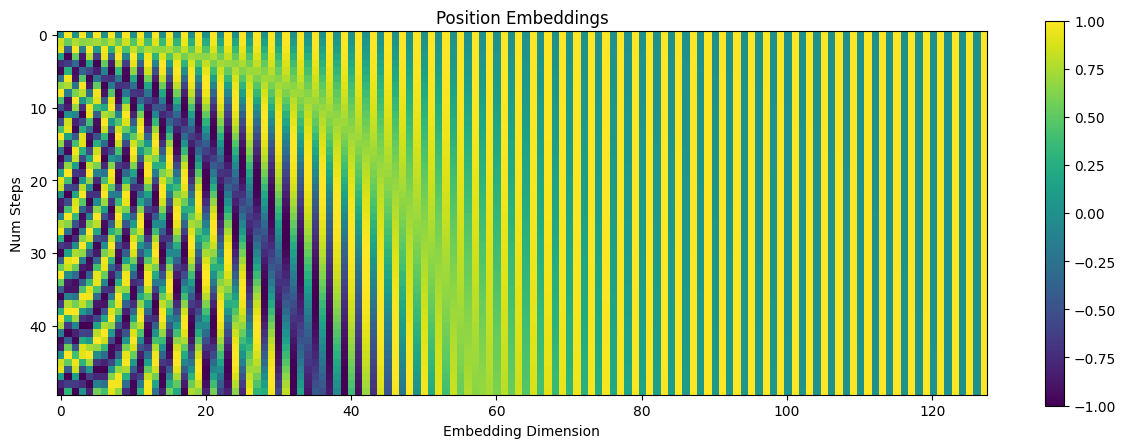

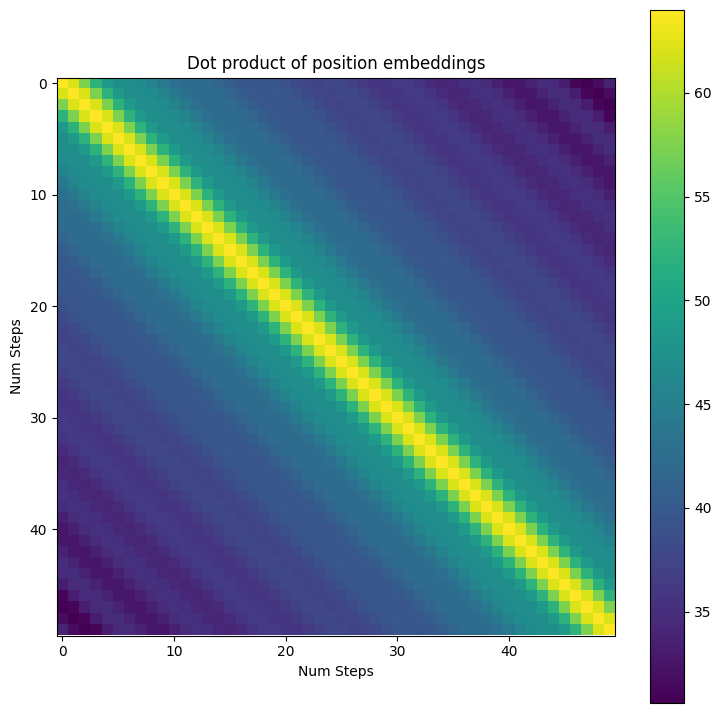

In [47]:
emb = SinusoidalPositionEmbeddings(128)
out = emb(t.arange(50))

fig, ax = plt.subplots(figsize=(15, 5))
ax.set(xlabel="Embedding Dimension", ylabel="Num Steps", title="Position Embeddings")
im = ax.imshow(out, vmin=-1, vmax=1)
fig.colorbar(im)

fig, ax = plt.subplots(figsize=(9, 9))
im = ax.imshow(out @ out.T)
fig.colorbar(im)
ax.set(xlabel="Num Steps", ylabel="Num Steps", title="Dot product of position embeddings")

# Sigmoid Linear Unit

The Sigmoid Linear Unit (SiLu) (also sometimes called "Swish") nonlinearity is simply elementwise `x * sigmoid(x)`. 

TLDR: It's just another activation function that claims to lead to better performance. For more details about this activation function, [Swish: A Self-Gated Activation Function](https://arxiv.org/pdf/1710.05941v1).

In [48]:
def swish(x: t.Tensor) -> t.Tensor:
    return x * x.sigmoid()


class SiLU(nn.Module):
    def forward(self, x: t.Tensor) -> t.Tensor:
        return swish(x)

[Text(0.5, 0, 'x'), Text(0, 0.5, 'swish(x)')]

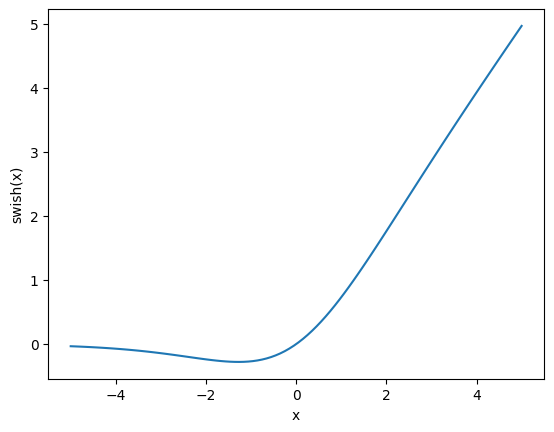

In [49]:
silu = SiLU()


fig, ax = plt.subplots()
x = t.linspace(-5, 5, 100)
ax.plot(x, silu(x))
ax.set(xlabel="x", ylabel="swish(x)")

# Self-Attention and the Attention Block

<img src="references/self_attention.png" alt="Multi-Head Attention">
<figcaption><code>Figure 2</code> from Vaswani et al. (2017) in <a href="https://arxiv.org/pdf/1706.03762#page=4">Attention Is All You Need</a></figcaption>

The self-attention mechanism in the DDPM model look very similar to the self-attention mechanism used in LLMs like GPT. However, in the DDPM model, there is no causal attnetion meaning that we don't need to apply as mask. Also, instead of having only one spatial dimension (token sequences), we have image data that has two spatial dimensions (height and width). 


In [50]:
class SelfAttention(nn.Module):
    def __init__(self, channels: int, num_heads: int = 4):
        """Self-Attention with two spatial dimensions.

        channels: the number of channels. Should be divisible by the number of heads.
        """
        super().__init__()
        self.channels = channels
        self.num_heads = num_heads
        assert channels % num_heads == 0
        self.head_size = channels // num_heads
        self.in_proj = nn.Linear(channels, channels * 3) # 3 for Key (W_K), Query (W_Q), and Value (W_V) vectors
        self.out_proj = nn.Linear(channels, channels) # Ouput (W_O)

    def forward(self, x: t.Tensor) -> t.Tensor:
        """
        x: shape (batch, channels, height, width)
        out: shape (batch, channels, height, width)
        """
        b, c, h, w = x.shape
        assert self.channels == c

        # Reshape 2D image into sequence of feature vectors
        x = rearrange(x, "batch channels height width -> batch (height width) channels") 

        # Project input into query, key, and value vectors all at once
        qkv = self.in_proj(x).chunk(3, dim=-1)

        # Separate Q, K, V and reshape to split channels into multiple heads
        q, k, v = [
            rearrange(tensor, "batch seq (head head_size) -> batch head seq head_size", head=self.num_heads)
            for tensor in qkv
        ]

        # Compute and scale attention scores 
        out = einsum("batch head seq_q head_size, batch head seq_k head_size -> batch head seq_q seq_k", q, k)
        out = out / (self.head_size**0.5)
        attn = out.softmax(dim=-1)

        # Use attention probabilties to computed a weighted sum of values 
        out = einsum("batch head seq_k head_size, batch head seq_q seq_k -> batch head seq_q head_size", v, attn)

        # Combine all heads and restore original sequence dimension
        out = rearrange(out, "batch head seq head_size -> batch seq (head head_size)")

        # Final projection to mix information between heads
        out = self.out_proj(out)

        # Reshape back into a 2D image 
        out = rearrange(out, "batch (height width) channels -> batch channels height width", height=h, width=w)

        return out

In [51]:
tests.unet_architecture_tests.test_self_attention(SelfAttention)

tests.unet_architecture_tests.test_self_attention passed in 0.09s.


Below is a diagram of the AttentionBlock. It is pretty straight forward. There is a GroupNorm layer, followed the self-attention layer implemented above that gets added back to the residual stream at the very end.

<img src="references/attention_block.png" alt="Attention Block
graph TD
    subgraph AttentionBlock
        Image --> GroupNorm[Group Norm<br/>1 group] --> Self-Attention[Self-Attention<br/>4 heads] --> Output
        Image --> Output
    end"
 width="322.33333333" height="640">

In [52]:
class AttentionBlock(nn.Module):
    def __init__(self, channels: int):
        super().__init__()
        self.norm = GroupNorm(1, channels)
        self.attn = SelfAttention(channels)

    def forward(self, x: t.Tensor) -> t.Tensor:
        return x + self.attn(self.norm(x))

In [53]:
tests.unet_architecture_tests.test_attention_block(SelfAttention)

tests.unet_architecture_tests.test_attention_block passed in 0.07s.


In [54]:
class ResidualBlock(nn.Module):
    def __init__(self, input_channels: int, output_channels: int, step_dim: int, groups: int):
        """
        input_channels: number of channels in the input to foward
        output_channels: number of channels in the returned output
        step_dim: embedding dimension size for the number of steps
        groups: number of groups in the GroupNorms

        Note that the conv in the left branch is needed if c_in != c_out.
        """
        super().__init__()
        self.mlp = nn.Sequential(
            SiLU(), nn.Linear(step_dim, output_channels)
        )  # start with silu because time_mlp in the base ended in Linear without nonlinearity

        self.block1 = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, 3, padding=1), GroupNorm(groups, output_channels), SiLU()
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(output_channels, output_channels, 3, padding=1), GroupNorm(groups, output_channels), SiLU()
        )
        self.res_conv = (
            nn.Conv2d(input_channels, output_channels, 1) if input_channels != output_channels else nn.Identity() # extra convolution to get the input/output dimensions to match
        )

    def forward(self, x: t.Tensor, time_emb: t.Tensor) -> t.Tensor:
        h = self.block1(x)

        time_emb = self.mlp(time_emb)
        h = rearrange(time_emb, "b c -> b c 1 1") + h # matching up matrix dimensions
        h = self.block2(h)
        return h + self.res_conv(x)

In [55]:
tests.unet_architecture_tests.test_residual_block(ResidualBlock)

tests.unet_architecture_tests.test_residual_block passed in 0.00s.


# Downsampling Block

The downblock takes in an input with height `h` and an embedding for the number of steps `NumSteps` and returns: a skip output of height `h` to the corresponding `UpBlock` **AND** a dampsampled output of height `h//2`

<img src="references/down_block.png" alt="Down Block"
data-mermaid="
graph TD
    subgraph DownBlock
        NumSteps -->|emb| DResnetBlock1 & DResnetBlock2
        DImage[Input] -->|c_in, h| DResnetBlock1[Residual Block 1] -->|c_out, h| DResnetBlock2[Residual Block 2] -->|c_out, h| DAttention[Attention Block] -->|c_out, h| DConv2d[4x4 Conv<br/>Stride 2<br/>Padding 1] -->|c_out, h/2| Output
        DAttention -->|c_out, h| SkipToUpBlock[Skip To<br/>UpBlock]
    end
" width="277" height="640">

In [56]:
class DownBlock(nn.Module):
    def __init__(
        self,
        channels_in: int,
        channels_out: int,
        time_emb_dim: int,
        groups: int,
        downsample: bool,
    ):
        super().__init__()
        self.block0 = ResidualBlock(channels_in, channels_out, time_emb_dim, groups)
        self.block1 = ResidualBlock(channels_out, channels_out, time_emb_dim, groups)
        self.attn = AttentionBlock(channels_out)
        self.downsample = nn.Conv2d(channels_out, channels_out, 4, 2, 1) if downsample else nn.Identity()

    def forward(self, x: t.Tensor, step_emb: t.Tensor) -> tuple[t.Tensor, t.Tensor]:
        """
        x: shape (batch, channels, height, width)
        step_emb: shape (batch, emb)
        Return: (downsampled output, full size output to skip to matching UpBlock)
        """
        B, C, H, W = x.shape
        x = self.block0(x, step_emb)
        x = self.block1(x, step_emb)
        skip = self.attn(x)
        if isinstance(self.downsample, nn.Conv2d):
            assert H % 2 == 0, f"{H} not divisible by 2 - this will break the upsample later"
            assert W % 2 == 0, f"{W} not divisible by 2 - this will break the upsample later"
        x = self.downsample(skip)
        return x, skip


In [57]:
tests.unet_architecture_tests.test_downblock(DownBlock, downsample=True)
tests.unet_architecture_tests.test_downblock(DownBlock, downsample=False)


tests.unet_architecture_tests.test_downblock passed in 0.01s.
tests.unet_architecture_tests.test_downblock passed in 0.00s.


# MidBlock (Bottneck)

<img src="references/up_block.png" alt="Mid Block"
data-mermaid="
graph TD
    subgraph MidBlock
        UNumSteps[NumSteps] -->|emb| UResnetBlock1 & UResnetBlock2
        UImage[Image] -->|c_mid, h| UResnetBlock1[Residual Block 1] -->|c_mid, h| UAttention[Attention Block] -->|c_mid, h| UResnetBlock2[Residual Block 2] -->|c_mid, h| UOutput[Output]
    end
" width="345.3" height="640">

After passing through all the `DownBlocks`, the image tensor is passed through `MidBlocks` which doesn't modify the tensor dimensions. 

In [58]:
class MidBlock(nn.Module):
    def __init__(self, mid_dim: int, time_emb_dim: int, groups: int):
        super().__init__()
        self.mid_block1 = ResidualBlock(mid_dim, mid_dim, time_emb_dim, groups)
        self.mid_attn = AttentionBlock(mid_dim)
        self.mid_block2 = ResidualBlock(mid_dim, mid_dim, time_emb_dim, groups)

    def forward(self, x: t.Tensor, step_emb: t.Tensor):
        x = self.mid_block1(x, step_emb)
        x = self.mid_attn(x)
        x = self.mid_block2(x, step_emb)
        return x

In [59]:
tests.unet_architecture_tests.test_midblock(MidBlock)

tests.unet_architecture_tests.test_midblock passed in 0.01s.


# Upsampling Block

<img src="references/up_block.png" alt="Up Block"
data-mermaid="
graph TD
    subgraph UpBlock
        UNumSteps[NumSteps] -->|emb| UResnetBlock1 & UResnetBlock2
        Skip[Skip From<br/>DownBlock<br/>] -->|c_out, h| Concatenate
        UImage[Image] -->|c_out, h| Concatenate -->|2*c_out, h| UResnetBlock1[Residual Block 1] -->|c_in, h| UResnetBlock2[Residual Block 2] -->|c_in, h| UAttention[Attention Block] -->|c_in, h| DConvTranspose2d[4x4 Transposed Conv<br/>Stride 2<br/>Padding 1] -->|c_in, 2h| UOutput[Output]
    end
" width="301" height="640">

In addition to `NumSteps` and the image data, the `UpBlock` also takes in a skip connection from the corresponding `DownBlock` (i.e. the first `UpBlock` corresponds to the last `DownBlock`, second `UpBlock` corresponds to the second to last `DownBlock`, etc).

Note: The shape dimensions `c_in` and `c_out` are with respect to the corresponding `DownBlock`. It's confusing either way you try to label it.

In [60]:
class UpBlock(nn.Module):
    def __init__(self, dim_in: int, dim_out: int, time_emb_dim: int, groups: int, upsample: bool):
        super().__init__()
        self.block0 = ResidualBlock(dim_out * 2, dim_in, time_emb_dim, groups)
        self.block1 = ResidualBlock(dim_in, dim_in, time_emb_dim, groups)
        self.attn = AttentionBlock(dim_in)
        self.upsample = nn.ConvTranspose2d(dim_in, dim_in, 4, 2, 1) if upsample else nn.Identity()

    def forward(self, x: t.Tensor, step_emb: t.Tensor, skip: t.Tensor) -> t.Tensor:
        x = t.cat((x, skip), dim=1)  # cat along channel dim
        x = self.block0(x, step_emb)
        x = self.block1(x, step_emb)
        x = self.attn(x)
        x = self.upsample(x)
        return x

In [61]:
tests.unet_architecture_tests.test_upblock(UpBlock, upsample=True)
tests.unet_architecture_tests.test_upblock(UpBlock, upsample=False)

tests.unet_architecture_tests.test_upblock passed in 0.00s.
tests.unet_architecture_tests.test_upblock passed in 0.00s.


# Putting everything together

Now that we have implemented all of the pieces, we can put stitch together the entire model. Here is the high level diagram of the DDPM model again:

<img src="references/DDPM-architecture.png" 
alt="U-Net Architecture\"
data-mermaid="
graph TD
    subgraph DDPM Architecture
        subgraph Overview
            MTime[Num Noise Steps] --> MTimeLayer[SinusoidalEmbedding<br/>Linear: Steps -> 4C<br/>GELU<br/>Linear: 4C -> 4C]
            MTimeLayer -->|emb|DownBlock0 & DownBlock1 & DownBlock2 & MidBlock & UpBlock0 & UpBlock1 & OutBlock
            Image -->|3, H| InConv[7x7 Conv<br/>Padding 3] -->|C, H| DownBlock0 -->|C, H/2| DownBlock1 -->|2C,H/4| DownBlock2 -->|4C,H/4| MidBlock -->|4C,H/4| UpBlock0 -->|2C,H/2| UpBlock1 -->|C,H| OutBlock[Residual Block] -->|C,H| FinalConv[1x1 Conv] -->|3,H| Output
            DownBlock2 -->|4C,H/4| UpBlock0
            DownBlock1 -->|2C,H/2| UpBlock1
        end
end
">


In [62]:
class Unet(nn.Module):
    def __init__(
        self,
        image_shape: tuple[int, int, int],
        channels: int = 128,
        dim_mults: tuple[int, ...] = (1, 2, 4, 8),
        groups: int = 4,
        max_steps: int = 1000,
    ):
        """
        image_shape: the input and output image shape, a tuple of (C, H, W)
        channels: the number of channels after the first convolution.
        dim_mults: the number of output channels for downblock i is dim_mults[i] * channels. Note that the default arg of (1, 2, 4, 8) will contain one more DownBlock and UpBlock than the DDPM image above.
        groups: number of groups in the group normalization of each ResnetBlock (doesn't apply to attention block)
        max_steps: the max number of (de)noising steps. We also use this value as the sinusoidal positional embedding dimension (although in general these do not need to be related).
        """
        self.noise_schedule = None
        self.img_shape = image_shape
        super().__init__()
        time_emb_dim = 4 * channels
        self.init_conv = nn.Conv2d(image_shape[0], channels, 7, padding=3)
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(max_steps),
            nn.Linear(max_steps, time_emb_dim),
            nn.GELU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )

        dims = [channels] + [channels * m for m in dim_mults]
        in_out = list(zip(dims[:-1], dims[1:]))
        print("Channel sizes for in/out:", in_out) 

        self.downs = nn.ModuleList([])
        for i, (dim_in, dim_out) in enumerate(in_out):
            is_last = i >= len(in_out) - 1
            self.downs.append(DownBlock(dim_in, dim_out, time_emb_dim, groups, not is_last))

        self.mid = MidBlock(dims[-1], time_emb_dim, groups)

        self.ups = nn.ModuleList([])
        for i, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = i >= len(in_out) - 1
            self.ups.append(UpBlock(dim_in, dim_out, time_emb_dim, groups, not is_last))

        self.final_block = ResidualBlock(channels, channels, time_emb_dim, groups)
        self.final_conv = nn.Conv2d(channels, image_shape[0], 1)

    def forward(self, x: t.Tensor, num_steps: t.Tensor) -> t.Tensor:
        """
        x: shape (batch, channels, height, width)
        num_steps: shape (batch, )

        out: shape (batch, channels, height, width)
        """
        x = self.init_conv(x)
        step_emb = self.time_mlp(num_steps)
        skips = [] # push/pop to match `UpBlocks` to `DownBlocks`
        for d in self.downs:
            assert isinstance(d, DownBlock)
            x, skip = d(x, step_emb)
            skips.append(skip)

        x = self.mid(x, step_emb)

        for u in self.ups:
            assert isinstance(u, UpBlock)
            skip = skips.pop()
            x = u(x, step_emb, skip)

        x = self.final_block(x, step_emb)
        x = self.final_conv(x)
        return x

In [63]:
tests.unet_architecture_tests.test_unet(Unet)

Channel sizes for in/out: [(8, 8), (8, 16), (16, 32)]
tests.unet_architecture_tests.test_unet passed in 0.04s.
